<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/Vega_Ferrero_v_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.stats import norm
from scipy import integrate
import matplotlib.pyplot as plt

Для начала посмотрим на формулу (5) из нашей статьи: $$P(H_0|D) \propto P(H_0) \int d \Delta t_{X1} d \mu_{X1} p_m (\Delta t_{X1}, \mu_{X1}|H_0, G) \cdot p_d (\Delta t_{X1}, \mu_{X1}|LC)$$
Разберём её по порядку (но сразу отметим, что обе вероятности под интегралом нормированы на единицу): 

1) $P(H_0)$ - априорная вероятность (credibility) того, что постоянная Хаббла примет такое значение. В этой работе указано: "Hereafter, we assume a very conservaive UNIFORM prior $P(H_0)$ between $H_0 = 30 \ and \ 100 \ km \ s^{-1} \ Mpc^{-1}$". То есть, эта величина постоянна.

2) $p_m (\Delta t_{X1}, \mu_{X1}|H_0, G)$ - распределение вероятности для каждой из моделей ("For each individuallens model, we adopt a bivariate but separable normal distribution").

Указанная выше вероятность $p_m (\Delta t_{X1}, \mu_{X1}|H_0, G)$ равна произведению вероятностей p_dt_model и p_mu_model, но, так как указанный выше интеграл можно будет свести к двум одномерным, мы пока не будем усложнять код. Отметим пока супер-важную вещь: нам необходимо поменять аргумент вероятности, связанной с $\Delta t$, так как все модели предполагают, что $H_0 = 70 \ km \ s^{-1} \ Mpc^{-1}$.

3) $p_d (\Delta t_{X1}, \mu_{X1}|LC)$ - вероятность, основанная на наблюдательных данных. Она не зависит от $H_0$. "For the observational data, we associate a bivariate normal distribution, based on the best-fit ellipse to the 68% CL (confidence level) in Figure 3 of Kelly et al. (2016a)". Идём в эту статью, смотрим на упомянутый "эллипс" (который на самом деле является вытянутым и изогнутым).

Попробуем подобрать параметры этого эллипса:

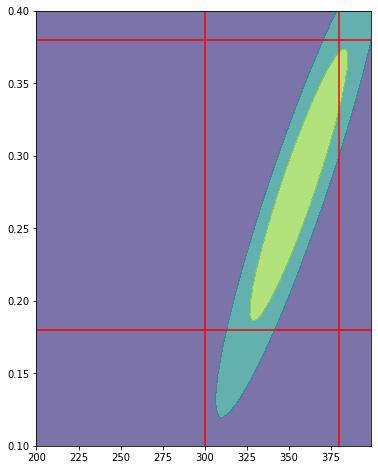

In [0]:
from scipy.stats import multivariate_normal

x, y = np.mgrid[200:400:1, 0.1:0.4:0.01]
pos = np.dstack((x,y))

means = [356, 0.28]
sigmas = [34, 0.11]
rho = 0.93 #коэффициент корреляции
cov = [ [sigmas[0]**2, rho*sigmas[0]*sigmas[1]],[rho*sigmas[0]*sigmas[1],sigmas[1]**2] ]

rv = multivariate_normal(means, cov)

import matplotlib.image as mpimg

fig = plt.figure(figsize=(6,8))

#img = mpimg.imread('kellyetal.jpg')

ax = fig.add_subplot(111)

#ax.imshow(img, extent=[200, 400, 0.1, 0.4], aspect = 1000)

ax.contourf(x,y, rv.pdf(pos), 2, alpha=0.7)

ax.axvline(300, color='red'); ax.axvline(380, color='red')
ax.axhline(0.18, color='red'); ax.axhline(0.38, color='red')

plt.show()

In [0]:
dt_X1_data = means[0]
sigma_dt_X1_data = sigmas[0]

mu_X1_data = means[1]
sigma_mu_X1_data = sigmas[1]

In [0]:
print('DATA:')
print("Delta t =", means[0], "+-", sigmas[0])
print("mu =", means[1], "+-", sigmas[1])
print('rho =', rho)

DATA:
Delta t = 356 +- 34
mu = 0.28 +- 0.11
rho = 0.93


$$ p_d (\Delta t_{X1}, \mu_{X1}|LC) = \frac{1}{(\sqrt{2\pi})^2\sigma_{\Delta t}\sigma_{\mu} \sqrt{1-\rho^2}} \exp\Big( - \frac{1}{2} Q(\Delta t_{X1} - {\Delta t}_{mean}, \mu_{X1} - {\mu}_{mean}) \Big),$$

$$Q(y_1,y_2)=\frac{1}{1-\rho^2} \Big(\frac{y_1^2}{\sigma_1^2} - 2\rho \frac{y_1y_2}{\sigma_1\sigma_2} + \frac{y_2^2}{\sigma_2^2} \Big)$$


Данные моделей:

In [0]:
names =  ['Die-16',     'Die-a',   'Gri-g',   'Ogu-g', 'Ogu-a', 'Sha-a', 'Sha-g',  'Petr']
colors = ['sandybrown', 'magenta', 'orange',  'blue',  'green', 'black', 'indigo', 'red']

dt_X1_model =             [376, 262, 361, 311, 336, 233, 277, 316] #среднее
sigma_right_dt_X1_model = [ 25,  55,  19,  24,  21,  46,  11,  59] #погрешность справа
sigma_left_dt_X1_model =  [ 25,  55,  27,  24,  21,  13,  21,  84] #погрешность слева

mu_X1_model =             [0.30, 0.31, 0.36, 0.27, 0.27, 0.19, 0.25, 0.21] #среднее
sigma_right_mu_X1_model = [0.05, 0.10, 0.11, 0.05, 0.03, 0.01, 0.05, 0.12] #погрешность справа
sigma_left_mu_X1_model =  [0.05, 0.10, 0.09, 0.05, 0.03, 0.04, 0.02, 0.06] #погрешность слева

Определим несимметричную гауссиану и нормируем её (внимание, возможно, придётся менять пределы интегрирования при подсчёте площади):

In [0]:
def nonsym_gauss(x, mean, sigma_left, sigma_right):       #поточечно
    
    pdf = 0
        
    if x >= mean:
        pdf = np.exp( - (x - mean)**2/2/sigma_right**2 )
    else:
        pdf = np.exp( - (x - mean)**2/2/sigma_left**2 )
    
    area_left  =  integrate.quad(lambda t: np.exp( - (t - mean)**2/2/sigma_left**2 ), 0,    mean)
    area_right =  integrate.quad(lambda t: np.exp( - (t - mean)**2/2/sigma_right**2 ), mean, 1000)
    
    area = area_left[0] + area_right[0]
    
    return pdf/area 

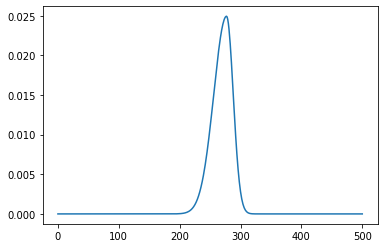

In [0]:
xs = np.linspace(0, 500, 501)

pdf=np.zeros(len(xs))

for i in range(0, len(xs)):
    pdf[i] = nonsym_gauss(xs[i], dt_X1_model[-2], sigma_left_dt_X1_model[-2], sigma_right_dt_X1_model[-2])

plt.plot(xs, pdf)
plt.show()

#print((xs.max()-xs.min())/(len(xs)-1), np.diff(xs))

#print(sum(pdf)*np.diff(xs)[0])

Умножаем $p_d (\Delta t_{X1}, \mu_{X1}|LC)$ на нормальные распределения с параметрами из модели и всё это интегрируем.

In [0]:
#def binormal(x, y, m_x, m_y, s_x, s_y, ro):
#    return 1/2/np.pi/s_x/s_y/np.sqrt(1-ro**2) * np.exp( - 1/2/(1-ro**2) * ( (x - m_x)**2/s_x**2 - 2*ro* x*y/s_x/s_y + (y - m_y)**2/s_y**2 ) )

In [0]:
H_0_fid = 70. #km/s/Mpc
H_0s = np.linspace(30, 100, 71)

PDFs = np.zeros((len(names), len(H_0s)))

for i in range(0, len(names)-1):

    P_prom = []
    
    for j in range(0, len(H_0s)):
        
        P_H_0 = 1./len(H_0s)

        # x - время, y - усиление
        
        int = integrate.nquad(lambda x, y: 1/2/np.pi/sigma_dt_X1_data/sigma_mu_X1_data/np.sqrt(1-rho**2) * 
                              
                                np.exp( - 1/2/(1-rho**2) * ( (x - dt_X1_data)**2/sigma_dt_X1_data**2 - 
                                                            
                                2*rho*(x - dt_X1_data)*(y - mu_X1_data)/sigma_dt_X1_data/sigma_mu_X1_data + 
                                
                                (y - mu_X1_data)**2/sigma_mu_X1_data**2 ) ) * 
                              
                                nonsym_gauss(x, (H_0_fid/H_0s[j])*dt_X1_model[i], 
                                             sigma_left_dt_X1_model[i], sigma_right_dt_X1_model[i]) *
                              
                                nonsym_gauss(y, mu_X1_model[i], 
                                             sigma_left_mu_X1_model[i], sigma_right_mu_X1_model[i]),
                                
                                [[0, 500], [0, 1]] )
        print(names[i], j/len(H_0s))#, end='\r')

        #P_prom = np.append(P_final, P_H_0 * int[0])
        PDFs[i][j] = P_H_0 * int[0]

Die-16 0.0
Die-16 0.014084507042253521
Die-16 0.028169014084507043
Die-16 0.04225352112676056
Die-16 0.056338028169014086
Die-16 0.07042253521126761
Die-16 0.08450704225352113
Die-16 0.09859154929577464
Die-16 0.11267605633802817
Die-16 0.1267605633802817
Die-16 0.14084507042253522
Die-16 0.15492957746478872
Die-16 0.16901408450704225
Die-16 0.18309859154929578
Die-16 0.19718309859154928
Die-16 0.2112676056338028
Die-16 0.22535211267605634
Die-16 0.23943661971830985
Die-16 0.2535211267605634
Die-16 0.2676056338028169
Die-16 0.28169014084507044
Die-16 0.29577464788732394
Die-16 0.30985915492957744
Die-16 0.323943661971831
Die-16 0.3380281690140845
Die-16 0.352112676056338
Die-16 0.36619718309859156
Die-16 0.38028169014084506
Die-16 0.39436619718309857
Die-16 0.4084507042253521
Die-16 0.4225352112676056
Die-16 0.43661971830985913
Die-16 0.4507042253521127
Die-16 0.4647887323943662
Die-16 0.4788732394366197
Die-16 0.49295774647887325
Die-16 0.5070422535211268
Die-16 0.5211267605633803
Die

In [0]:
import pandas as pd

spisok = pd.DataFrame(PDFs).to_csv('vega-ferrero_PDFs.csv', index=False)

from google.colab import files; files.download('vega-ferrero_PDFs.csv')
#print(PDFs)

#with open('pdfs.txt', 'w') as file:
#    json.dump(list(PDFs), file)

In [0]:
data = pd.read_csv('vega-ferrero_PDFs.csv', sep="\t", header=None)
data

,0
0,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."
1,"7.611795058411976e-67,1.3269257806735574e-59,2..."
2,"8.666569305574038e-08,3.201163956866087e-07,9...."
3,"1.437846671273741e-45,3.4624933792441432e-40,1..."
4,"5.1772238704054996e-37,6.842216965503139e-33,2..."
5,"2.9367048231499133e-64,3.34987431407999e-57,4...."
6,"5.614527250289232e-34,2.5003874149089945e-29,2..."
7,"4.015228864137483e-28,9.994548017014183e-25,8...."
8,"0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0...."


In [0]:
fig = plt.figure(figsize=(8,6))

for i in range(0, len(names)):

    plt.plot(H_0s, PDFs[i], label = names[i], color=colors[i])
    plt.legend()
    plt.xlabel('$H_0, km/s/Mpc$', fontsize=15)
    plt.ylabel('P($H_0$|D)', fontsize=15)

#plt.axvline(H_0s[np.argmax(PDFs[-1])], color='black', linestyle='--')    
plt.grid()
plt.show()

NameError: ignored

Посмотрим на графики из статьи (наблюдается несоответствие по амплитудам):

![vegaferrero.jpg](attachment:vegaferrero.jpg)

Определим функцию, которая возвращает индексы элементов, соответствующих границам интервала в 68%, вдоль горизонтальной оси:

In [0]:
def f1sb(xs, distribution, percents, plot, Print): #find 1 sigma borders
    
    area = sum(distribution)*np.diff(xs)[0]
    pdf = distribution/area
    cdf = np.cumsum(pdf)*np.diff(H_0s)[0]
    
    leftb_perc = (1-percents)/2.
    rightb_perc = 1-leftb_perc
    
    left_ind = np.argmin(np.abs(cdf - leftb_perc))
    right_ind = np.argmin( np.abs(cdf - rightb_perc) )
    middle_ind = np.argmin( np.abs(cdf - .5) )
    
    if plot == True:
        
        plt.plot(H_0s, cdf, 'r:')
        
        plt.axhline(leftb_perc,color='m')
        plt.axhline(rightb_perc,color='m')

        plt.axvline(H_0s[left_ind],color='g')
        plt.axvline(H_0s[right_ind],color='g')
        plt.axvline(H_0s[middle_ind],color='g')
    
    if Print == True:
        print('Mean: H_0=', H_0s[middle_ind])
        print('Left border: H_0=', H_0s[left_ind])
        print('Right border: H_0=', H_0s[right_ind])
        print('Left sigma =', H_0s[middle_ind] - H_0s[left_ind])
        print('Right sigma =', H_0s[right_ind] - H_0s[middle_ind])

    return H_0s[middle_ind], H_0s[middle_ind] - H_0s[left_ind], H_0s[right_ind] - H_0s[middle_ind]

Отдельно перемножим и сложим получившиеся вероятности:

In [0]:
P_mult = np.ones(len(H_0s))
P_sum = np.zeros(len(H_0s))

for i in range(0, len(names)-2):
    #print(P_mult)
    P_mult = PDFs[i] * P_mult
    P_sum = P_sum + PDFs[i]/(len(names)-1)

P_mult_mean, sigma_P_mult_left, sigma_P_mult_right = f1sb(H_0s, P_mult, .68, plot=False, Print=False)

P_sum_mean, sigma_P_sum_left, sigma_P_sum_right = f1sb(H_0s, P_sum, .68, plot=False, Print=False)

For P_x(H_0|D):
H_0 = 65.0 + 3.0 - 2.0 (program)
H_0 = 62 + 4 - 4 (Vega-Ferrero)

For P_+(H_0|D):
H_0 = 66.0 + 8.0 - 10.0 (program)
H_0 = 64 + 9 - 11 (Vega-Ferrero)


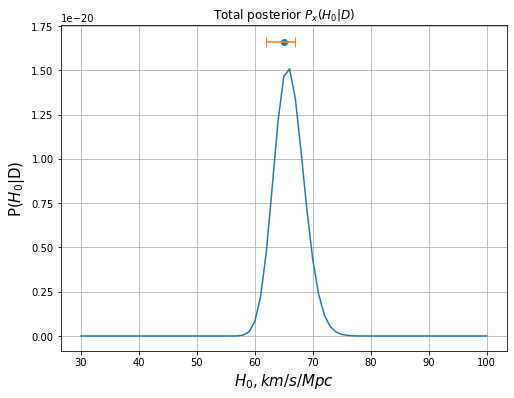

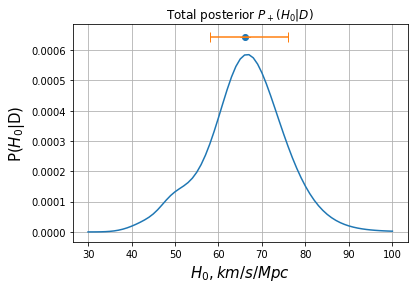

In [0]:
print('For P_x(H_0|D):')
print('H_0 =', P_mult_mean, '+', sigma_P_mult_right, '-', sigma_P_mult_left, '(program)')
print('H_0 = 62 + 4 - 4 (Vega-Ferrero)')
print()
print('For P_+(H_0|D):')
print('H_0 =', P_sum_mean, '+', sigma_P_sum_right, '-', sigma_P_sum_left, '(program)')
print('H_0 = 64 + 9 - 11 (Vega-Ferrero)')

fig = plt.figure(figsize=(8,6))

plt.grid()
plt.xlabel('$H_0, km/s/Mpc$', fontsize=15)
plt.ylabel('P($H_0$|D)', fontsize=15)
plt.title('Total posterior $P_x(H_0|D)$')

plt.plot(H_0s, P_mult)#, label = '$P_х(H_0|D)$', linestyle='--')
plt.scatter(P_mult_mean, 1.1*P_mult[np.argmax(P_mult)])
plt.errorbar(P_mult_mean, 1.1*P_mult[np.argmax(P_mult)], 0, [[sigma_P_mult_left], [sigma_P_mult_right]], capsize=5)
plt.show()

plt.grid()
plt.xlabel('$H_0, km/s/Mpc$', fontsize=15)
plt.ylabel('P($H_0$|D)', fontsize=15)
plt.title('Total posterior $P_+(H_0|D)$')

plt.plot(H_0s, P_sum)#, label = '$P_+(H_0|D)$', linestyle='--')
plt.scatter(P_sum_mean, 1.1*P_sum[np.argmax(P_sum)])
plt.errorbar(P_sum_mean, 1.1*P_sum[np.argmax(P_sum)], 0, [[sigma_P_sum_left], [sigma_P_sum_right]], capsize=5)


plt.show()